# BERT

## Imported Libraries

The code imports essential Python libraries for mathematical operations (`math`), regular expressions (`re`), random number generation (`random`), numerical computing (`numpy`), and deep learning with PyTorch (`torch`). Specifically, PyTorch modules for neural networks (`torch.nn`) and optimization (`torch.optim`) are imported. These imports lay the groundwork for various computational tasks, including data manipulation, model building, and optimization.


In [5]:
import math
import re
from random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## 1. Data


The dataset "nuvocare/WikiMedical_sentence_similarity" from Hugging Face provides pairs of sentences with similarity labels, suitable for tasks like semantic similarity assessment in the medical domain.



The dataset consists of a train set with 50,712 pairs and a test set with 21,735 pairs. After splitting, the new train set contains 43,355 pairs, and the new test set contains 7,357 pairs.


In [6]:
from datasets import load_dataset
# Load the dataset
dataset = load_dataset("nuvocare/WikiMedical_sentence_similarity")


/Users/shafisourov/anaconda3/envs/nlu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 50712
    })
    test: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 21735
    })
})

In [8]:
# # Define the split sizes
# train_size = 85
# val_size = 15 
# test_size = 15  # Explicit for clarity, though it's simply 100 - 85

# # Apply the split to both 'train' and 'test' sets in the DatasetDict
# new_train = dataset['train'].select(range(train_size))
# new_test = dataset['train'].select(range(train_size, train_size + val_size))
# new_test = dataset['train'].select(range(train_size + val_size, train_size + val_size + test_size))

# # Additionally, if you wish to apply the split to the original 'test' dataset as well, you can do:
# # For clarity, showing how to reassign within the DatasetDict, but typically, you adjust only the 'train' part for such operations
# dataset['train'] = new_train
# dataset['test'] = dataset['test'].select(range(test_size))

# # Confirming the new sizes
# print(f"New Train dataset size: {len(dataset['train'])}")
# print(f"New Test dataset size: {len(dataset['test'])}")

# Define the split sizes
train_size = 85
val_size = 15 
test_size = 15  # Explicit for clarity, though it's simply 100 - 85

# Apply the split to both 'train' and 'test' sets in the DatasetDict
new_train = dataset['train'].select(range(train_size))
new_val = dataset['train'].select(range(train_size, train_size + val_size))
new_test = dataset['train'].select(range(train_size + val_size, train_size + val_size + test_size))

# Additionally, if you wish to apply the split to the original 'test' dataset as well, you can do:
# For clarity, showing how to reassign within the DatasetDict, but typically, you adjust only the 'train' part for such operations
dataset['train'] = new_train
dataset['validation'] = new_val
dataset['test'] = new_test

# Confirming the new sizes
print(f"New Train dataset size: {len(dataset['train'])}")
print(f"New Validation dataset size: {len(dataset['validation'])}")
print(f"New Test dataset size: {len(dataset['test'])}")

New Train dataset size: 85
New Validation dataset size: 15
New Test dataset size: 15


In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 85
    })
    test: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 15
    })
    validation: Dataset({
        features: ['text1', 'text2', 'label'],
        num_rows: 15
    })
})

## 2. Preprocessing

### Tokenization and numericalization

## Transformation of Dataset

The provided code demonstrates the transformation of a dataset using a custom function named `transform_data`. Here's a breakdown of the process:

1. **Imports**: The code imports necessary libraries such as `datasets`, `numpy`, `random`, and `re`.

2. **Transformation Function**: The `transform_data` function defines a transformation process for each example in the dataset. It preprocesses text data by converting it to lowercase and removing punctuation. Then, it randomly selects pairs of sentences and assigns a binary label (`isNext`) based on whether they are similar or not.

3. **Application of Transformation**: The transformation is applied directly to each split in the dataset (`train` and `test`) using the `map` function. The transformation function is applied to each example, and the original columns (`text1`, `text2`, `label`) are removed.

4. **Result**: The transformed dataset (`transformed_dataset`) is obtained, containing the preprocessed examples with the new structure. The sizes of the transformed train and test datasets are printed for verification.


In [11]:
from datasets import load_dataset
import numpy as np
import random
import re

# Define your transformation function
def transform_data(example):
    text1 = re.sub("[.,!?\\-]", '', example['text1'].lower())
    text2 = re.sub("[.,!?\\-]", '', example['text2'].lower())
    label = example['label']

    if np.random.random() < 0.5:
        return {'text1': text1, 'text2': text2, 'isNext': label == 1}  # Assuming 1 indicates similarity
    else:
        return {'text1': text2, 'text2': text1, 'isNext': label == 1}  # Flip text1 and text2

# Assuming 'dataset' is your DatasetDict
# Apply the transformation directly to each split in the DatasetDict
transformed_dataset = {
    split: dataset[split].map(transform_data, remove_columns=['text1', 'text2', 'label'])
    for split in dataset.keys()
}

# Now, 'transformed_dataset' should be correctly transformed
print(f"Transformed Train dataset size: {len(transformed_dataset['train'])}")
print(f"Transformed Validation dataset size: {len(transformed_dataset['validation'])}")
print(f"Transformed Test dataset size: {len(transformed_dataset['test'])}")


Transformed Train dataset size: 85
Transformed Validation dataset size: 15
Transformed Test dataset size: 15


In [12]:
transformed_dataset

{'train': Dataset({
     features: ['text1', 'text2', 'isNext'],
     num_rows: 85
 }),
 'test': Dataset({
     features: ['text1', 'text2', 'isNext'],
     num_rows: 15
 }),
 'validation': Dataset({
     features: ['text1', 'text2', 'isNext'],
     num_rows: 15
 })}

## Tokenization and Vocabulary Building

The provided code demonstrates tokenization of text data using the `torchtext` library and building a vocabulary from the tokenized text. Here's a summary of the process:

1. **Imports**: Necessary libraries such as `torch`, `datasets`, `torchtext`, and related modules are imported.

2. **Tokenization**: The `tokenize_data` function is defined to tokenize text data in batches. It tokenizes each text in the batch for both 'text1' and 'text2' fields.

3. **Tokenization Application**: Tokenization is applied to each split in the transformed dataset using the `map` function. The tokenized texts are stored in a new column and the original text columns ('text1' and 'text2') are removed.

4. **Vocabulary Building**:
    - The special tokens for padding, classification, separator, masking, and unknown tokens are defined.
    - A custom function `flat_map` is defined to flatten the token lists.
    - The `build_vocab_from_iterator` function is called to build a vocabulary from the flattened token lists of the training data, considering the defined special tokens.
    - The default index of the vocabulary is set to the unknown token ('[UNK]').
    
5. **Vocabulary Saving**: The built vocabulary is saved for later use.



In [13]:
import torch
from datasets import load_dataset
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

# Load the 'basic_english' tokenizer
tokenizer = get_tokenizer('basic_english')
# Adjust the tokenize_data function to handle batch processing
def tokenize_data(batch, tokenizer):
    # Tokenize each text in the batch for text1 and text2
    text1_tokens = [tokenizer(text) for text in batch['text1']]
    text2_tokens = [tokenizer(text) for text in batch['text2']]
    # Return a dictionary with the tokenized texts
    return {'text1_tokens': text1_tokens, 'text2_tokens': text2_tokens}

# Apply tokenization to each split in your transformed dataset
tokenized_dataset = {
    split: transformed_dataset[split].map(lambda batch: tokenize_data(batch, tokenizer), batched=True, remove_columns=['text1', 'text2'])
    for split in transformed_dataset.keys()
}

# Proceed with building the vocab
special_tokens = ['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]']

# Since build_vocab_from_iterator expects a flat iterator of tokens, you need to flatten the token lists
def flat_map(tokens_lists):
    for tokens in tokens_lists:
        for token in tokens:
            yield token

# Adjust the call to build_vocab_from_iterator
vocab = build_vocab_from_iterator(
    flat_map(tokenized_dataset['train']['text1_tokens'] + tokenized_dataset['train']['text2_tokens']),
    specials=special_tokens
)
vocab.set_default_index(vocab['[UNK]'])

# Save vocab for later use
torch.save(vocab, './model/vocab.pt')


Map: 100%|██████████| 15/15 [00:00<00:00, 410.25 examples/s]


In [14]:
print(f"Total number of tokens in vocab: {len(vocab)}")


Total number of tokens in vocab: 93


In [15]:
tokens_to_check = ['[PAD]', '[CLS]', '[SEP]', '[MASK]', '[UNK]', 'the', 'of', 'and']
for token in tokens_to_check:
    print(f"Index of '{token}': {vocab[token]}")


Index of '[PAD]': 0
Index of '[CLS]': 1
Index of '[SEP]': 2
Index of '[MASK]': 3
Index of '[UNK]': 4
Index of 'the': 4
Index of 'of': 4
Index of 'and': 4


In [16]:
tokenized_dataset['train'][0]

{'isNext': False,
 'text1_tokens': ['econometric',
  'studies',
  'have',
  'shown',
  'that',
  'this',
  'effect',
  'cannot',
  'be',
  'explained',
  'by',
  'a',
  'variety',
  'of',
  'alternative',
  'factors',
  'including',
  'differential',
  'trends',
  'across',
  'areas',
  'changing',
  'crop',
  'prices',
  'shifts',
  'in',
  'certain',
  'educational',
  'and',
  'health',
  'policies',
  'and',
  'the',
  'effect',
  'of',
  'malaria',
  'eradication',
  'no',
  'significant',
  'contemporaneous',
  'results',
  'were',
  'found',
  'for',
  'adults',
  'who',
  'should',
  'have',
  'benefited',
  'less',
  'from',
  'the',
  'intervention',
  'owing',
  'to',
  'their',
  'substantially',
  'lower',
  '(',
  'prior',
  ')',
  'infection',
  'rates',
  'the',
  'program',
  'nearly',
  'eradicated',
  'hookworm',
  'and',
  'would',
  'flourish',
  'afterward',
  'with',
  'new',
  'funding',
  'as',
  'the',
  'rockefeller',
  'foundation',
  'international',
  'hea

## 3. Data loader

We gonna make dataloader.  Inside here, we need to make two types of embeddings: **token embedding** and **segment embedding**

1. **Token embedding** - Given “The cat is walking. The dog is barking”, we add [CLS] and [SEP] >> “[CLS] the cat is walking [SEP] the dog is barking”. 

2. **Segment embedding**
A segment embedding separates two sentences, i.e., [0 0 0 0 1 1 1 1 ]

3. **Masking**
As mentioned in the original paper, BERT randomly assigns masks to 15% of the sequence. In this 15%, 80% is replaced with masks, while 10% is replaced with random tokens, and the rest 10% is left as is.  Here we specified `max_pred` 

4. **Padding**
Once we mask, we will add padding. For simplicity, here we padded until some specified `max_len`. 

Note:  `positive` and `negative` are just simply counts to keep track of the batch size.  `positive` refers to two sentences that are really next to one another.

## Data Preparation and DataLoader Creation

The provided code prepares the data for training a model. Here's a summary of the process:

1. **Imports**: Necessary libraries such as `torch`, `tqdm`, and `numpy` are imported, along with `DataLoader` and `Dataset` from `torch.utils.data`.

2. **Batch Creation Function**: The `make_batch` function creates batches of data. It tokenizes the text, adds special tokens, generates segment embeddings, predicts mask positions, and pads the sequences to a maximum length.

3. **Custom Collate Function**: The `custom_collate_fn` function defines how to collate the batches, ensuring that the tensors are stacked properly.

4. **Parameters**: Parameters such as batch size, maximum mask count, and maximum sequence length are defined.

5. **Data Preparation**: The `make_batch` function is applied to both the training and validation datasets, producing batches of preprocessed data.

6. **DataLoaders**: DataLoader objects are created for both the training and validation data, specifying batch size, shuffling for the training set, and using the custom collate function.

7. **Example Usage**: An example of how to iterate over one batch from the training DataLoader is demonstrated.

In [17]:
import torch
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, Dataset

# Assuming vocab and transformed_dataset are already defined and loaded

def make_batch(dataset, vocab, max_mask, max_len):
    data = []
    
    for example in tqdm(dataset):
        # Transform the list of tokens to list of token indices based on vocab
        tokens_a = [vocab[token] if token in vocab else vocab['[UNK]'] for token in example['text1_tokens']]
        tokens_b = [vocab[token] if token in vocab else vocab['[UNK]'] for token in example['text2_tokens']]

        # 1. Token embedding - add CLS and SEP
        input_ids = [vocab['[CLS]']] + tokens_a + [vocab['[SEP]']] + tokens_b + [vocab['[SEP]']]

        # 2. Segment embedding - which sentence is 0 and 1
        segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

        # Ensure length does not exceed max_len
        input_ids = input_ids[:max_len]
        segment_ids = segment_ids[:max_len]

        # 3. Predicted mask positions
        n_pred = min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        candidates_masked_pos = [i for i, token in enumerate(input_ids) if token != vocab['[CLS]'] and token != vocab['[SEP]']]
        np.random.shuffle(candidates_masked_pos)
        masked_tokens, masked_pos = [], []

        for pos in candidates_masked_pos[:n_pred]:
            masked_pos.append(pos)
            masked_tokens.append(input_ids[pos])
            rand_val = np.random.random()
            if rand_val < 0.1:
                input_ids[pos] = vocab[vocab.get_itos()[np.random.randint(5, len(vocab) - 1)]]
            elif rand_val < 0.8:
                input_ids[pos] = vocab['[MASK]']

        # 4. Pad the sentences and masks to max_len
        n_pad = max_len - len(input_ids)
        input_ids.extend([vocab['[PAD]']] * n_pad)
        segment_ids.extend([0] * n_pad)

        n_pad = max_mask - len(masked_tokens)
        masked_tokens.extend([0] * n_pad)
        masked_pos.extend([0] * n_pad)

        instance = [input_ids, segment_ids, masked_tokens, masked_pos, [int(example['isNext'])]]
        instance = [torch.LongTensor(i) for i in instance]
        data.append(instance)
        
    return data

def custom_collate_fn(batch):
    input_ids = torch.stack([item[0] for item in batch])
    segment_ids = torch.stack([item[1] for item in batch])
    masked_tokens = torch.stack([item[2] for item in batch])
    masked_pos = torch.stack([item[3] for item in batch])
    isNext = torch.stack([item[4] for item in batch])
    return input_ids, segment_ids, masked_tokens, masked_pos, isNext

# Parameters
batch_size = 16
max_mask = 5
max_len = 512

# Prepare the data
train_data = make_batch(tokenized_dataset['train'], vocab, max_mask, max_len)
val_data = make_batch(tokenized_dataset['validation'], vocab, max_mask, max_len)
test_data = make_batch(tokenized_dataset['test'], vocab, max_mask, max_len)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=custom_collate_fn)


100%|██████████| 15/15 [00:00<00:00, 531.42it/s]


## 4. Model

Recall that BERT only uses the encoder.

BERT has the following components:

- Embedding layers
- Attention Mask
- Encoder layer
- Multi-head attention
- Scaled dot product attention
- Position-wise feed-forward network
- BERT (assembling all the components)

## 4.1 Embedding

<img src = "./figures/BERT_embed.png" width=500>

## Embedding Module

The provided code defines an `Embedding` class, which serves as an embedding layer incorporating token, positional, and segment embeddings. Here's a summary of the module:

- **Class**: `Embedding(nn.Module)`

- **Initialization**:
  - The constructor `__init__` initializes the embedding layers:
    - `tok_embed`: Token embedding layer initialized with an embedding matrix of size `(vocab_size, d_model)`.
    - `pos_embed`: Positional embedding layer initialized with an embedding matrix of size `(max_len, d_model)`, where `max_len` represents the maximum sequence length.
    - `seg_embed`: Segment (or token type) embedding layer initialized with an embedding matrix of size `(n_segments, d_model)`.
    - `norm`: Layer normalization applied to the final embedding.
    - `device`: The device (e.g., CPU or GPU) on which the operations will be performed.

- **Forward Pass**:
  - The `forward` method takes input tokens `x` and segment embeddings `seg`.
  - It calculates the positional embeddings based on the sequence length.
  - It adds the token, positional, and segment embeddings together.
  - Layer normalization is applied to the combined embeddings.
  - The normalized embeddings are returned.


In [272]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_len, n_segments, d_model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        #x, seg: (bs, len)
        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (len,) -> (bs, len)
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

## 4.2 Attention mask


The provided code defines a function `get_attn_pad_mask` to create an attention mask for padding tokens. Here's a summary:

- **Function**: `get_attn_pad_mask(seq_q, seq_k, device)`

- **Arguments**:
  - `seq_q`: Input sequence of queries.
  - `seq_k`: Input sequence of keys.
  - `device`: The device (e.g., CPU or GPU) on which the operations will be performed.

- **Functionality**:
  - It determines the padding tokens in the input sequence (`seq_k`) by checking if the token index is zero (which typically represents a PAD token).
  - It creates a mask of shape `(batch_size, len_q, len_k)`, where `len_q` and `len_k` are the lengths of the query and key sequences, respectively.
  - The mask is expanded along the batch dimension to match the batch size of the input sequences.

- **Return**:
  - Returns the attention mask for padding tokens.

In [273]:
def get_attn_pad_mask(seq_q, seq_k, device):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

### Testing the attention mask

In [274]:
print(get_attn_pad_mask(input_ids, input_ids, 'cpu').shape)

torch.Size([16, 512, 512])


## 4.3 Encoder

The encoder has two main components: 

- Multi-head Attention
- Position-wise feed-forward network

First let's make the wrapper called `EncoderLayer`

## Encoder Layer Module

The provided code defines an `EncoderLayer` class, representing one layer in the encoder of a transformer model. Here's a summary:

- **Class**: `EncoderLayer(nn.Module)`

- **Initialization**:
  - The constructor `__init__` initializes the encoder layer with parameters:
    - `n_heads`: Number of attention heads.
    - `d_model`: Dimensionality of the model.
    - `d_ff`: Dimensionality of the feed-forward layer.
    - `d_k`: Dimensionality of the key vectors.
    - `device`: The device (e.g., CPU or GPU) on which the operations will be performed.
  - It creates two sub-modules:
    - `enc_self_attn`: Multi-head self-attention module initialized with the provided parameters.
    - `pos_ffn`: Position-wise feed-forward network module initialized with the provided dimensionality.

- **Forward Pass**:
  - The `forward` method takes encoder inputs (`enc_inputs`) and self-attention mask (`enc_self_attn_mask`).
  - It applies multi-head self-attention to the inputs using the `enc_self_attn` module.
  - The outputs of the self-attention module are then passed through the position-wise feed-forward network (`pos_ffn`).
  - The final encoder outputs and attention weights are returned.

In [275]:
class EncoderLayer(nn.Module):
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn       = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

Let's define the scaled dot attention, to be used inside the multihead attention

## Scaled Dot-Product Attention Module

The provided code defines a `ScaledDotProductAttention` class, representing the scaled dot-product attention mechanism used in transformer models. Here's a summary:

- **Class**: `ScaledDotProductAttention(nn.Module)`

- **Initialization**:
  - The constructor `__init__` initializes the attention mechanism with the dimensionality of the key vectors (`d_k`) and the device on which operations will be performed (`device`).
  - It calculates the scale factor for scaling the dot-product scores.

- **Forward Pass**:
  - The `forward` method takes query (`Q`), key (`K`), and value (`V`) tensors, along with an attention mask (`attn_mask`).
  - It calculates the dot-product of query and key tensors and scales it by the square root of the dimensionality of the key vectors.
  - The attention scores are masked using the provided attention mask.
  - The masked scores are passed through a softmax function to obtain attention weights.
  - The context vector is calculated by weighted summing the values with the attention weights.
  - The context vector and attention weights are returned.


In [276]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn 

Here is the Multiheadattention.

## Multi-Head Attention Module

The provided code defines a `MultiHeadAttention` class, which implements the multi-head attention mechanism in transformer models. Here's a summary:

- **Class**: `MultiHeadAttention(nn.Module)`

- **Initialization**:
  - The constructor `__init__` initializes the multi-head attention mechanism with parameters:
    - `n_heads`: Number of attention heads.
    - `d_model`: Dimensionality of the model.
    - `d_k`: Dimensionality of the key vectors.
    - `device`: The device (e.g., CPU or GPU) on which the operations will be performed.
  - It creates linear transformation layers (`W_Q`, `W_K`, `W_V`) to project input queries, keys, and values into the multi-head space.

- **Forward Pass**:
  - The `forward` method takes query (`Q`), key (`K`), and value (`V`) tensors, along with an attention mask (`attn_mask`).
  - It projects the input tensors into the multi-head space using linear transformations and splits them into multiple heads.
  - The scaled dot-product attention is applied to each head.
  - The context vectors from all heads are concatenated and linearly transformed back to the original dimensionality.
  - Layer normalization is applied to the output, and the residual connection is added.
  - The output and attention weights are returned.


In [277]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, self.d_v * n_heads)
        self.device = device
    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], k: [batch_size x len_k x d_model], v: [batch_size x len_k x d_model]
        residual, batch_size = Q, Q.size(0)
        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1) # attn_mask : [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = nn.Linear(self.n_heads * self.d_v, self.d_model, device=self.device)(context)
        return nn.LayerNorm(self.d_model, device=self.device)(output + residual), attn # output: [batch_size x len_q x d_model]

Here is the PoswiseFeedForwardNet.

## Position-wise Feed-Forward Network Module

The provided code defines a `PoswiseFeedForwardNet` class, which implements the position-wise feed-forward network used in transformer models. Here's a summary:

- **Class**: `PoswiseFeedForwardNet(nn.Module)`

- **Initialization**:
  - The constructor `__init__` initializes the feed-forward network with parameters:
    - `d_model`: Dimensionality of the input and output tensors.
    - `d_ff`: Dimensionality of the hidden layer.
  - It creates two linear transformation layers (`fc1`, `fc2`) with appropriate input and output dimensions.

- **Forward Pass**:
  - The `forward` method takes input tensor `x`.
  - It applies the first linear transformation followed by the GELU activation function (`F.gelu`) and then the second linear transformation.
  - The output tensor is returned.


In [278]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        # (batch_size, len_seq, d_model) -> (batch_size, len_seq, d_ff) -> (batch_size, len_seq, d_model)
        return self.fc2(F.gelu(self.fc1(x)))

## 4.4 Putting them together

## BERT Model

The provided code defines a `BERT` class, which represents a BERT (Bidirectional Encoder Representations from Transformers) model. Here's a summary:

- **Class**: `BERT(nn.Module)`

- **Initialization**:
  - The constructor `__init__` initializes the BERT model with parameters such as the number of layers, number of attention heads, dimensionality of the model, etc.
  - It initializes the embedding layer, encoder layers, classification layers, and decoder.

- **Forward Pass**:
  - The `forward` method takes input IDs, segment IDs, and masked positions.
  - It passes the inputs through the embedding layer and multiple encoder layers.
  - It predicts the next sentence and masked tokens.
  - The outputs of both tasks are returned.

- **Helper Method**:
  - The `get_last_hidden_state` method takes input IDs and segment IDs.
  - It passes the inputs through the embedding layer and multiple encoder layers.
  - It returns the last hidden state of the encoder layers.


In [279]:
class BERT(nn.Module):
    def __init__(self, n_layers, n_heads, d_model, d_ff, d_k, n_segments, vocab_size, max_len, device):
        super(BERT, self).__init__()
        self.params = {'n_layers': n_layers, 'n_heads': n_heads, 'd_model': d_model,
                       'd_ff': d_ff, 'd_k': d_k, 'n_segments': n_segments,
                       'vocab_size': vocab_size, 'max_len': max_len}
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        self.layers = nn.ModuleList([EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 2)
        # decoder is shared with embedding layer
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        self.device = device

    def forward(self, input_ids, segment_ids, masked_pos):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output : [batch_size, len, d_model], attn : [batch_size, n_heads, d_mode, d_model]
        
        # 1. predict next sentence
        # it will be decided by first token(CLS)
        h_pooled   = self.activ(self.fc(output[:, 0])) # [batch_size, d_model]
        logits_nsp = self.classifier(h_pooled) # [batch_size, 2]

        # 2. predict the masked token
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1)) # [batch_size, max_pred, d_model]
        h_masked = torch.gather(output, 1, masked_pos) # masking position [batch_size, max_pred, d_model]
        h_masked  = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias # [batch_size, max_pred, n_vocab]

        return logits_lm, logits_nsp
    
    def get_last_hidden_state(self, input_ids, segment_ids):
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)

        return output

## 5. Training

## Setting Device and Seed

- **Device Selection**:
  - The code checks if CUDA (GPU) is available. If it is, it sets the device to 'cuda'; otherwise, it sets it to 'cpu'.
  - This ensures that the model and computations will be performed on the available hardware resource (GPU if available, otherwise CPU).

- **Setting Seed for Reproducibility**:
  - The code sets a manual seed (`SEED`) to ensure reproducibility of results across multiple runs.
  - Additionally, it enables deterministic behavior of the CuDNN backend for CUDA operations, further enhancing reproducibility.


In [280]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


### BERT Model Configuration

In [29]:
n_layers = 6    # number of Encoder of Encoder Layer
n_heads  = 8    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = 768 * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2

### BERT Model Initialization

- The BERT model is initialized using the specified configuration parameters:
  - Number of Encoder Layers: 6
  - Number of Attention Heads: 8
  - Embedding Size: 768
  - FeedForward Dimension: 3072
  - Dimension of K(=Q) and V: 64
  - Number of Segments: 2
  - Vocabulary Size: Determined by the length of the vocabulary
  - Maximum Sequence Length: Determined by the maximum length of sequences
  - Device: Determined by the availability of CUDA (GPU) or CPU
  
- The model is then moved to the selected device (CUDA if available, otherwise CPU) using `.to(device)`.

- **Loss Function**:
  - Cross-entropy loss (`nn.CrossEntropyLoss()`) is chosen as the criterion for training.

- **Optimizer**:
  - Adam optimizer (`optim.Adam`) is used with a learning rate of 5e-5, following the setting used in the BERT paper.


In [41]:
model = BERT(n_layers, n_heads, d_model, d_ff, d_k, n_segments, len(vocab), max_len, device).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)  # BERT paper used 5e-5

In [30]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)


37073759


## Training Function

The provided `train` function is used to train the BERT model. Here's a summary of its functionality:

- **Input**:
  - `model`: The BERT model to be trained.
  - `data`: The DataLoader containing the training data.
  - `optimizer`: The optimizer used for updating model parameters.
  - `criterion`: The loss function used for calculating the loss.
  - `device`: The device (CPU or GPU) where the model and data are located.

- **Functionality**:
  - Sets the model to training mode.
  - Iterates over batches of data from the DataLoader.
  - Zeroes the gradients of the optimizer.
  - Transfers input data to the specified device.
  - Computes the forward pass through the model to obtain predictions.
  - Calculates the masked language model (MLM) loss and next sentence prediction (NSP) loss.
  - Combines both losses and computes the total loss.
  - Backpropagates the total loss and updates the model parameters using the optimizer.
  - Returns the mean loss over all batches for the epoch.

- **Note**:
  - MLM loss is calculated based on the predicted masked tokens compared to the actual masked tokens.
  - NSP loss is calculated based on the predicted next sentence classification compared to the actual next sentence labels.

In [283]:
def train(model, data, optimizer, criterion, device):
    epoch_loss = []
    model.train()

    for input_ids, segment_ids, masked_tokens, masked_pos, isNext in tqdm(data, desc='Training: '):
        optimizer.zero_grad()
        input_ids = input_ids.to(device)
        segment_ids = segment_ids.to(device)
        masked_tokens = masked_tokens.to(device)
        masked_pos = masked_pos.to(device)
        isNext = isNext.flatten().to(device)
        logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)    
        #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
        #logits_nsp: (bs, yes/no) ==> (6, 2)

        #1. mlm loss
        #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
        loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
        loss_lm = (loss_lm.float()).mean()
        #2. nsp loss
        #logits_nsp: (bs, 2) vs. isNext: (bs, )
        loss_nsp = criterion(logits_nsp, isNext) # for sentence classification
        
        #3. combine loss
        loss = loss_lm + loss_nsp
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    return np.mean(epoch_loss)

### Evaluation Function

The provided `evaluate` function is used to evaluate the performance of the BERT model on the validation or test dataset. Here's a summary of its functionality:

- **Input**:
  - `model`: The BERT model to be evaluated.
  - `data`: The DataLoader containing the evaluation data.
  - `criterion`: The loss function used for calculating the loss.
  - `device`: The device (CPU or GPU) where the model and data are located.

- **Functionality**:
  - Sets the model to evaluation mode.
  - Iterates over batches of data from the DataLoader.
  - Transfers input data to the specified device.
  - Computes the forward pass through the model to obtain predictions.
  - Calculates the masked language model (MLM) loss and next sentence prediction (NSP) loss.
  - Combines both losses and computes the total loss.
  - Returns the mean loss over all batches for the evaluation dataset.

- **Note**:
  - Similar to the `train` function, MLM loss and NSP loss are calculated based on the predicted masked tokens and next sentence classification compared to the actual values.
  - The `torch.no_grad()` context manager is used to disable gradient calculation, speeding up computation and reducing memory cost during evaluation.


In [284]:
def evaluate(model, data, criterion, device):
    epoch_loss = []
    model.eval()

    with torch.no_grad():  # set the 'requires_grad' to False to speed up computation and reduce memory cost
        for input_ids, segment_ids, masked_tokens, masked_pos, isNext in tqdm(data, desc='Evaluate: '):
            input_ids = input_ids.to(device)
            segment_ids = segment_ids.to(device)
            masked_tokens = masked_tokens.to(device)
            masked_pos = masked_pos.to(device)
            isNext = isNext.flatten().to(device)
            logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)    
            #logits_lm: (bs, max_mask, vocab_size) ==> (6, 5, 34)
            #logits_nsp: (bs, yes/no) ==> (6, 2)

            #1. mlm loss
            #logits_lm.transpose: (bs, vocab_size, max_mask) vs. masked_tokens: (bs, max_mask)
            loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens) # for masked LM
            loss_lm = (loss_lm.float()).mean()
            #2. nsp loss
            #logits_nsp: (bs, 2) vs. isNext: (bs, )
            loss_nsp = criterion(logits_nsp, isNext) # for sentence classification
            
            #3. combine loss
            loss = loss_lm + loss_nsp
            epoch_loss.append(loss.item())

    return np.mean(epoch_loss)

In [285]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Model Training Loop

The provided code snippet trains the BERT model over a specified number of epochs and evaluates its performance on a validation dataset. Here's a summary of the training loop:

- **Initialization**:
  - The training loop is configured with parameters such as the number of epochs (`num_epoch`), the path to save the best model (`save_path`), and a learning rate scheduler (`lr_scheduler`) to adjust the learning rate based on validation loss.

- **Training Loop**:
  - For each epoch, the loop iterates over the training DataLoader (`train_loader`) and evaluates the model's performance on the validation DataLoader (`val_loader`).
  - Training and evaluation losses are computed using the `train` and `evaluate` functions, respectively.
  - The learning rate scheduler (`lr_scheduler`) adjusts the learning rate based on the validation loss.
  - Training and validation losses are recorded for plotting.

- **Model Saving**:
  - The model is saved only if the validation loss improves compared to the previous best validation loss.
  - The model's parameters and state are saved to the specified file path (`save_path`).

- **Printed Information**:
  - For each epoch, the training time, training loss, and validation loss are printed.


In [286]:
import time
save_path = './model/bert_best_model.pt'
num_epoch = 10

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0)

best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epoch):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    lr_scheduler.step(val_loss)

    #for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the model only when its validation loss is lower than all its predecessors
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save([model.params, model.state_dict()], save_path)  # save the model's parameters and state to a file

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}')

Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.38s/it]


Epoch: 01 | Time: 2m 51s
	Train Loss: 23.529
	 Val. Loss: 27.009


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


Epoch: 02 | Time: 2m 46s
	Train Loss: 12.805
	 Val. Loss: 9.155


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


Epoch: 03 | Time: 2m 56s
	Train Loss: 8.529
	 Val. Loss: 7.790


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.08s/it]


Epoch: 04 | Time: 2m 34s
	Train Loss: 10.065
	 Val. Loss: 6.322


Evaluate: 100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


Epoch: 05 | Time: 2m 38s
	Train Loss: 6.418
	 Val. Loss: 7.046


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


Epoch: 06 | Time: 2m 25s
	Train Loss: 8.742
	 Val. Loss: 6.443


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]


Epoch: 07 | Time: 2m 34s
	Train Loss: 7.089
	 Val. Loss: 5.904


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]


Epoch: 08 | Time: 3m 13s
	Train Loss: 5.906
	 Val. Loss: 5.408


Evaluate: 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


Epoch: 09 | Time: 2m 41s
	Train Loss: 5.686
	 Val. Loss: 4.698


Evaluate: 100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


Epoch: 10 | Time: 2m 34s
	Train Loss: 4.103
	 Val. Loss: 4.110


In [3]:
# Calculate the average loss
average_loss = sum(train_losses) / len(train_losses)

# Display the average loss
print("Average Training Loss for BERT Scratch Model:", average_loss)


Average Training Loss for BERT Scratch Model: 9.2872


In [2]:
# Calculate the average validation loss
average_val_loss = sum(val_losses) / len(val_losses)

# Display the average validation loss
print("Average Validation Loss for BERT Scratch Model:", average_val_loss)


Average Validation Loss for BERT Scratch Model: 8.3885


In [49]:
from sklearn.metrics import precision_recall_fscore_support
import torch

def evaluate_and_predict(model, data_loader, criterion, device):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for input_ids, segment_ids, masked_tokens, masked_pos, isNext in data_loader:
            input_ids = input_ids.to(device)
            segment_ids = segment_ids.to(device)
            masked_pos = masked_pos.to(device)
            isNext = isNext.flatten().to(device)
            
            # Get model predictions
            logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
            # Here we focus on next sentence prediction task (isNext classification)
            logits = logits_nsp  # Assuming logits_nsp is the output for the next sentence prediction task

            # Calculate loss for tracking (optional)
            loss = criterion(logits, isNext)
            total_loss += loss.item()

            # Convert logits to probabilities and then to class predictions
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            # Collect predictions and true labels
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(isNext.cpu().numpy())

    # Calculate Precision, Recall, and F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    avg_loss = total_loss / len(data_loader)

    return precision, recall, f1, avg_loss

# Using the function to calculate metrics and average test loss
precision, recall, f1, avg_test_loss = evaluate_and_predict(model, test_loader, criterion, device)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Avg Test Loss: {avg_test_loss:.4f}")


Precision: 0.2178, Recall: 0.4667, F1 Score: 0.2970, Avg Test Loss: 0.7880


/Users/shafisourov/anaconda3/envs/nlu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Loss Visualization

The provided code snippet visualizes the training and validation losses over the training epochs using matplotlib. Here's a summary of the visualization:

- **Initialization**:
  - Matplotlib is imported (`import matplotlib.pyplot as plt`).

- **Visualization**:
  - A figure (`fig`) is created with a specific size (5x3) using `plt.figure(figsize=(5, 3))`.
  - An axis (`ax`) is added to the figure using `fig.add_subplot(1, 1, 1)`.
  - The training and validation losses are plotted using `ax.plot(train_losses, label='train loss')` and `ax.plot(val_losses, label='validation loss')`, respectively.
  - A legend is added to distinguish between the training and validation losses using `plt.legend()`.
  - The x-axis label is set to 'updates' and the y-axis label is set to 'loss' using `ax.set_xlabel('updates')` and `ax.set_ylabel('loss')`, respectively.

This visualization helps in monitoring the training progress and identifying potential overfitting or underfitting.


Text(0, 0.5, 'loss')

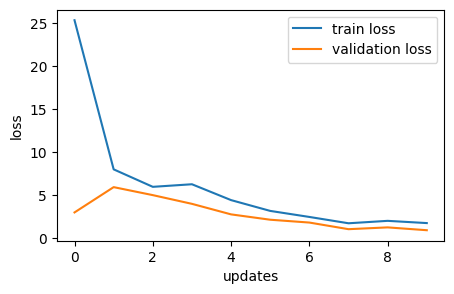

In [103]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(val_losses, label = 'validation loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

## 6. Inference

Since our dataset is very small, it won't work very well, but just for the sake of demonstration.

### Model Prediction Summary

The provided code snippet demonstrates how to use the trained BERT model to predict masked tokens and the next sentence prediction (isNext) on a validation dataset. Here's a summary of the prediction process:

1. **Initialization**:
   - The model, vocabulary, and parameters are loaded from saved files.
   - The model is moved to the appropriate device (GPU if available, otherwise CPU).

2. **Prediction Process**:
   - For each batch in the validation DataLoader (`val_loader`), a single data point is randomly selected.
   - The selected data point is processed using the `process_data_point` function, which takes the input data and performs predictions.
   - For masked tokens prediction:
     - The model predicts masked tokens using the provided input data.
     - The predicted masked tokens are printed alongside the actual masked tokens.
   - For next sentence prediction (isNext):
     - The model predicts whether the next sentence is true or false based on the provided input data.
     - The predicted isNext label is printed alongside the actual isNext label.

3. **Output**:
   - The predicted masked tokens and isNext label are printed for visualization.
   - Any errors that occur during the prediction process are caught and displayed.

This process helps in understanding how the trained BERT model performs on unseen data and provides insights into its predictions.


In [42]:
from model_class import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = './model/bert_best_model.pt'

In [43]:
# load the model and all its hyperparameters
params, state = torch.load(save_path)
model = BERT(**params, device=device).to(device)
model.load_state_dict(state)

<All keys matched successfully>

In [44]:
vocab = torch.load('./model/vocab.pt')

In [45]:
len(vocab)

93

In [31]:
# Predict mask tokens ans isNext
for input_ids, segment_ids, masked_tokens, masked_pos, isNext in val_loader:
    break

idx = 2
input_ids = input_ids[idx].reshape(1, -1).to(device)
segment_ids = segment_ids[idx].reshape(1, -1).to(device)
masked_tokens = masked_tokens[idx].reshape(1, -1).to(device)
masked_pos = masked_pos[idx].reshape(1, -1).to(device)
isNext = isNext[idx].item()

print([vocab.get_itos()[w.item()] for w in input_ids[0] if vocab.get_itos()[w.item()] != '[PAD]'])

logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
#logits_lm:  (1, max_mask, vocab_size) ==> (1, 5, 34)
#logits_nsp: (1, yes/no) ==> (1, 2)

#predict masked tokens
#max the probability along the vocab dim (2), [1] is the indices of the max, and [0] is the first value
logits_lm = logits_lm.data.cpu().max(2)[1][0].data.numpy() 
#note that zero is padding we add to the masked_tokens
print('masked tokens (words) : ',[vocab.get_itos()[pos.item()] for pos in masked_tokens[0] if pos.item() != 0])
print('masked tokens list : ',[pos.item() for pos in masked_tokens[0] if pos.item() != 0])
print('predicted masked tokens (words) : ',[vocab.get_itos()[pos.item()] for pos in logits_lm if pos.item() != 0])
print('predicted masked tokens list : ', [pos for pos in logits_lm if pos.item() != 0])

#predict nsp
logits_nsp = logits_nsp.data.cpu().max(1)[1][0].data.numpy()
print(logits_nsp)
print('isNext : ', True if isNext else False)
print('predict isNext : ', True if logits_nsp else False)

['[CLS]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'p', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '(', '[UNK]', '[UNK]', '[UNK]',

In [34]:
import torch
import random

def process_data_point(idx, input_ids, segment_ids, masked_tokens, masked_pos, isNext, device, model, vocab):
    """
    Process a single data point and print the prediction results.
    """
    # Reshape and send to device
    input_ids = input_ids[idx].reshape(1, -1).to(device)
    segment_ids = segment_ids[idx].reshape(1, -1).to(device)
    masked_tokens = masked_tokens[idx].reshape(1, -1).to(device)
    masked_pos = masked_pos[idx].reshape(1, -1).to(device)
    isNext = isNext[idx].item()

    print([vocab.get_itos()[w.item()] for w in input_ids[0] if vocab.get_itos()[w.item()] != '[PAD]'])

    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)

    # Process language model logits
    logits_lm = logits_lm.data.cpu().max(2)[1][0].data.numpy()
    print('Masked tokens (words):', [vocab.get_itos()[pos.item()] for pos in masked_tokens[0] if pos.item() != 0])
    print('Predicted masked tokens (words):', [vocab.get_itos()[pos.item()] for pos in logits_lm if pos.item() != 0])

    # Process next sentence prediction logits
    logits_nsp = logits_nsp.data.cpu().max(1)[1][0].data.numpy()
    print('isNext:', True if isNext else False)
    print('Predicted isNext:', True if logits_nsp else False)

# Predict mask tokens and isNext
try:
    for input_ids, segment_ids, masked_tokens, masked_pos, isNext in val_loader:
        # Randomly select an index from the batch
        batch_size = input_ids.size(0)
        idx = random.randint(0, batch_size - 1)

        process_data_point(idx, input_ids, segment_ids, masked_tokens, masked_pos, isNext, device, model, vocab)
        break  # Only process one batch for demonstration
except Exception as e:
    print(f"Error processing batch: {e}")


['[CLS]', '[UNK]', '[UNK]', '(', '[UNK]', '[UNK]', '[UNK]', ')', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'a', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'a', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'a', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'a', '[UNK]', '[UNK]', '[MASK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', 'a', '[UNK]', '[UNK]', '[MASK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]',

In [37]:
# The specific input example you provided
input_example = {
    'text1': ' econometric studies have shown that this effect cannot be explained by a variety of alternative factors including differential trends across areas changing crop prices shifts in certain educational and health policies and the effect of malaria eradication no significant contemporaneous results were found for adults who should have benefited less from the intervention owing to their substantially lower (prior) infection rates the program nearly eradicated hookworm and would flourish afterward with new funding as the rockefeller foundation international health divisionthe rfs hookworm campaign in mexico showed how science and politics play a role in developing health policies it brought together government officials health officials public health workers rockefeller officials and the community this campaign was launched to eradicate hookworms in mexico although the campaign did not focus on longterm treatments it did set the terms of the relationship between mexico and the rockefeller foundation the scientific knowledge behind this campaign helped shape public health policies improved public health and built a strong relationship between us and mexicoin the 1920s hookworm eradication reached the caribbean and latin america where great mortality was reported among people in the west indies towards the end of the 18th century as well as through descriptions sent from brazil and various other tropical and subtropical regions treatments\ntreatment in the early 20th century relied on the use of epsom salt to reduce protective mucus followed by thymol to kill the worms by the 1940s tetrachloroethylene was the leading method',
    'text2': '"spinraza access by country" treatsma 18 october 2018 retrieved 20190528',
    'isNext': False
}

# Assuming 'tokenizer', 'vocab', and 'device' are already defined and loaded

# Tokenize the input texts
text1_tokens = tokenizer(input_example['text1'])
text2_tokens = tokenizer(input_example['text2'])


# Convert tokens to vocab indices
tokens_a_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in text1_tokens]
tokens_b_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in text2_tokens]

# Prepare model inputs
input_ids = [vocab['[CLS]']] + tokens_a_idx + [vocab['[SEP]']] + tokens_b_idx + [vocab['[SEP]']]
segment_ids = [0] * (len(tokens_a_idx) + 2) + [1] * (len(tokens_b_idx) + 1)
input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
segment_ids = torch.tensor(segment_ids).unsqueeze(0).to(device)
masked_pos = torch.tensor([]).unsqueeze(0).to(device)  # No masked tokens in the inference example

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)

# Predicted isNext flag and confidence score
predicted_isNext = logits_nsp.argmax(dim=-1).item()
confidence_score = torch.nn.functional.softmax(logits_nsp, dim=-1).max().item()
predicted_isNext_text = "Yes" if predicted_isNext else "No"
original_isNext = "Yes" if input_example['isNext'] else "No"

# Display results
print("Original Text 1:\n", input_example['text1'])
print("\nOriginal Text 2:\n", input_example['text2'])
print(f"\nAre sentences next? {original_isNext} (Original)")
print(f"\nPredicted NSP: {predicted_isNext_text}")
print(f"\nNSP Score: {confidence_score:.4f} (Confidence)")

Original Text 1:
  econometric studies have shown that this effect cannot be explained by a variety of alternative factors including differential trends across areas changing crop prices shifts in certain educational and health policies and the effect of malaria eradication no significant contemporaneous results were found for adults who should have benefited less from the intervention owing to their substantially lower (prior) infection rates the program nearly eradicated hookworm and would flourish afterward with new funding as the rockefeller foundation international health divisionthe rfs hookworm campaign in mexico showed how science and politics play a role in developing health policies it brought together government officials health officials public health workers rockefeller officials and the community this campaign was launched to eradicate hookworms in mexico although the campaign did not focus on longterm treatments it did set the terms of the relationship between mexico and

In [38]:
import torch
import random

# Assuming 'model', 'tokenizer', 'vocab', 'device' are correctly defined

# Function to mask tokens
def mask_tokens(tokens, vocab, probability=0.15):
    masked_tokens = []
    masked_positions = []
    for i, token in enumerate(tokens):
        if random.random() < probability:
            masked_tokens.append('[MASK]')
            masked_positions.append(i)
        else:
            masked_tokens.append(token)
    return masked_tokens, masked_positions

# Randomly select an example from the test dataset
random_idx = random.randint(0, len(transformed_dataset['test']) - 1)
input_example = transformed_dataset['test'][random_idx]

# Tokenize the texts
text1_tokens = tokenizer(input_example['text1'])
text2_tokens = tokenizer(input_example['text2'])

# Mask tokens
masked_text1_tokens, _ = mask_tokens(text1_tokens, vocab)
masked_text2_tokens, _ = mask_tokens(text2_tokens, vocab)

# Convert tokens to indices, handling unknown tokens
tokens_a_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in masked_text1_tokens]
tokens_b_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in masked_text2_tokens]

# Prepare inputs
input_ids = [vocab['[CLS]']] + tokens_a_idx + [vocab['[SEP]']] + tokens_b_idx + [vocab['[SEP]']]
segment_ids = [0] * (len(tokens_a_idx) + 2) + [1] * (len(tokens_b_idx) + 1)
input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
segment_ids = torch.tensor(segment_ids).unsqueeze(0).to(device)

# Inference
model.eval()
with torch.no_grad():
    _, logits_nsp = model(input_ids, segment_ids, torch.tensor([]).unsqueeze(0).to(device))

# Display results
print("Original Text 1:", input_example['text1'])
print("Original Text 2:", input_example['text2'])
print("Masked Text 1:", ' '.join(masked_text1_tokens))
print("Masked Text 2:", ' '.join(masked_text2_tokens))
predicted_isNext = logits_nsp.argmax(dim=-1).item()
confidence_score = torch.nn.functional.softmax(logits_nsp, dim=-1).max().item()
predicted_isNext_text = "Yes" if predicted_isNext else "No"
original_isNext_text = "Yes" if input_example['isNext'] else "No"
print(f"Are sentences next? {original_isNext_text} (Original)")
print(f"Predicted NSP: {predicted_isNext_text}")
print(f"NSP Score: {confidence_score:.4f} (Confidence)")


Original Text 1: traffic accidents are the most common form of deadly injury causing about onethird of injuryrelated deaths onesixth are caused by suicide and onetenth are caused by homicide tens of millions of individuals require medical treatment for nonfatal injuries each year and injuries are responsible for about 10% of all years lived with disability men are twice as likely to be killed through injury than women in 2013 367000 children under the age of five died from injuries down from 766000 in 1990 classification systems
the world health organization (who) developed the international classification of external causes of injury (iceci) under this system injuries are classified by mechanism of injury objects/substances producing injury place of occurrence activity when injured the role of human intent and additional modules these codes allow the identification of distributions of injuries in specific populations and case identification for more detailed research on causes and pre

In [258]:
# Select a random sample from transformed_dataset['test']
random_idx = randint(0, len(transformed_dataset['test']) - 1)
input_example = transformed_dataset['test'][random_idx]


# Assuming 'tokenizer', 'vocab', and 'device' are already defined and loaded

# Tokenize the input texts
text1_tokens = tokenizer(input_example['text1'])
text2_tokens = tokenizer(input_example['text2'])


# Convert tokens to vocab indices
tokens_a_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in text1_tokens]
tokens_b_idx = [vocab[token] if token in vocab else vocab['[UNK]'] for token in text2_tokens]

# Prepare model inputs
input_ids = [vocab['[CLS]']] + tokens_a_idx + [vocab['[SEP]']] + tokens_b_idx + [vocab['[SEP]']]
segment_ids = [0] * (len(tokens_a_idx) + 2) + [1] * (len(tokens_b_idx) + 1)
input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
segment_ids = torch.tensor(segment_ids).unsqueeze(0).to(device)
masked_pos = torch.tensor([]).unsqueeze(0).to(device)  # No masked tokens in the inference example

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)

# Predicted isNext flag and confidence score
predicted_isNext = logits_nsp.argmax(dim=-1).item()
confidence_score = torch.nn.functional.softmax(logits_nsp, dim=-1).max().item()
predicted_isNext_text = "Yes" if predicted_isNext else "No"
original_isNext = "Yes" if input_example['isNext'] else "No"

# Display results
print("Original Text 1:\n", input_example['text1'])
print("\nOriginal Text 2:\n", input_example['text2'])
print(f"\nAre sentences next? {original_isNext} (Original)")
print(f"\nPredicted NSP: {predicted_isNext_text}")
print(f"\nNSP Score: {confidence_score:.4f} (Confidence)")

Original Text 1:
 these and other novel genes (dpti dptj) are believed to be involved in supplying the nonproteinogenic amino acids l3methylglutamic acid and kyn; they are located next to the nrps genesthe decanoic acid portion of daptomycin is synthesized by fatty acid synthase machinery (figure 2) posttranslational modification of the apoacyl carrier protein (acp thiolation or t domain) by a phosphopantetheinyltransferase (pptase) enzyme catalyzes the transfer of a flexible phosphopantetheine arm from coenzyme a to a conserved serine in the acp domain through a phosphodiester linkage the holoacp can provide a thiol on which the substrate and acyl chains are covalently bound during chain elongations the two core catalytic domains are an acyltransferase (at) and a ketosynthase (ks) the at acts upon a malonylcoa substrate and transfers an acyl group to the thiol of the acp domain this net transthiolation is an energyneutral step next the acylsacp gets transthiolated to a conserved cyste